In [1]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt

from tqdm.autonotebook import tqdm

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/tmp/ipykernel_932576/1477295042.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [3]:
import yfinance as yf

stock_prices = (
    yf.Tickers("aapl amd amzn crm goog meta msft nvda tsla")
    .history(period="max", start="2013-01-01")
    .Close
    .resample('1d')
    .ffill()
)

stock_prices

[*********************100%***********************]  9 of 9 completed


Ticker                           AAPL         AMD        AMZN         CRM  \
Date                                                                        
2013-01-02 00:00:00+00:00   16.705702    2.530000   12.865500   42.603367   
2013-01-03 00:00:00+00:00   16.494835    2.490000   12.924000   41.991089   
2013-01-04 00:00:00+00:00   16.035379    2.590000   12.957500   42.215092   
2013-01-05 00:00:00+00:00   16.035379    2.590000   12.957500   42.215092   
2013-01-06 00:00:00+00:00   16.035379    2.590000   12.957500   42.215092   
...                               ...         ...         ...         ...   
2024-09-15 00:00:00+00:00  222.500000  152.309998  186.490005  254.170975   
2024-09-16 00:00:00+00:00  216.320007  152.080002  184.889999  256.507294   
2024-09-17 00:00:00+00:00  216.789993  150.820007  186.880005  254.789993   
2024-09-18 00:00:00+00:00  220.690002  148.289993  186.429993  252.429993   
2024-09-19 00:00:00+00:00         NaN  154.529999  189.039993  260.160004   

Ticker                           GOOG        META        MSFT        NVDA  \
Date                                                                        
2013-01-02 00:00:00+00:00   17.969599   27.915949   22.451811    0.293535   
2013-01-03 00:00:00+00:00   17.980036   27.686640   22.151043    0.293765   
2013-01-04 00:00:00+00:00   18.335327   28.673666   21.736479    0.303458   
2013-01-05 00:00:00+00:00   18.335327   28.673666   21.736479    0.303458   
2013-01-06 00:00:00+00:00   18.335327   28.673666   21.736479    0.303458   
...                               ...         ...         ...         ...   
2024-09-15 00:00:00+00:00  158.369995  524.119995  430.589996  119.099998   
2024-09-16 00:00:00+00:00  158.990005  533.280029  431.339996  116.779999   
2024-09-17 00:00:00+00:00  160.279999  536.320007  435.149994  115.589996   
2024-09-18 00:00:00+00:00  160.809998  537.950012  430.809998  113.370003   
2024-09-19 00:00:00+00:00  162.854996         NaN  437.940002  118.270103   

Ticker                           TSLA  
Date                                   
2013-01-02 00:00:00+00:00    2.357333  
2013-01-03 00:00:00+00:00    2.318000  
2013-01-04 00:00:00+00:00    2.293333  
2013-01-05 00:00:00+00:00    2.293333  
2013-01-06 00:00:00+00:00    2.293333  
...                               ...  
2024-09-15 00:00:00+00:00  230.289993  
2024-09-16 00:00:00+00:00  226.779999  
2024-09-17 00:00:00+00:00  227.869995  
2024-09-18 00:00:00+00:00  227.199997  
2024-09-19 00:00:00+00:00  236.600006  

[4279 rows x 9 columns]

In [11]:
stock_returns = stock_prices.rolling(5).mean().pct_change().dropna()

stock_returns

/tmp/ipykernel_932576/312703872.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = stock_prices.rolling(5).mean().pct_change().dropna()


Ticker                         AAPL       AMD      AMZN       CRM      GOOG  \
Date                                                                          
2013-01-07 00:00:00+00:00 -0.009405  0.010946  0.008622 -0.002580  0.003141   
2013-01-08 00:00:00+00:00 -0.006343  0.013921  0.006056  0.001488  0.002622   
2013-01-09 00:00:00+00:00 -0.003764  0.003051  0.005487  0.002619  0.000041   
2013-01-10 00:00:00+00:00 -0.001332  0.002281  0.004691  0.004129  0.000953   
2013-01-11 00:00:00+00:00 -0.002561  0.006070  0.006631  0.004382  0.000548   
...                             ...       ...       ...       ...       ...   
2024-09-15 00:00:00+00:00  0.002152  0.012659  0.007510  0.006684  0.010795   
2024-09-16 00:00:00+00:00 -0.005697  0.002930  0.000397  0.005795  0.008738   
2024-09-17 00:00:00+00:00 -0.005404  0.000066 -0.000129  0.001429  0.006003   
2024-09-18 00:00:00+00:00 -0.001645 -0.005291 -0.000064 -0.001367  0.003072   
2024-09-19 00:00:00+00:00  0.000000  0.002937  0.002738  0.004708  0.005629   

Ticker                         META      MSFT      NVDA      TSLA  
Date                                                               
2013-01-07 00:00:00+00:00  0.009996 -0.006884  0.000770 -0.005885  
2013-01-08 00:00:00+00:00  0.008991 -0.005218 -0.003695 -0.006326  
2013-01-09 00:00:00+00:00  0.012642 -0.000300 -0.014526 -0.004439  
2013-01-10 00:00:00+00:00  0.017327 -0.002099 -0.014427 -0.005104  
2013-01-11 00:00:00+00:00  0.019848  0.000676 -0.014956 -0.008786  
...                             ...       ...       ...       ...  
2024-09-15 00:00:00+00:00  0.007652  0.007711  0.018905  0.003599  
2024-09-16 00:00:00+00:00  0.008409  0.003875 -0.000202 -0.001175  
2024-09-17 00:00:00+00:00  0.004265  0.003791 -0.005984 -0.001691  
2024-09-18 00:00:00+00:00  0.005235  0.000102 -0.009717 -0.002697  
2024-09-19 00:00:00+00:00  0.000000  0.003405 -0.001421  0.005523  

[4274 rows x 9 columns]

In [12]:
def _get_lag_llama_dataset(dataset):
    dataset = dataset.copy()

    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(dataset[col]):
            dataset[col] = dataset[col].astype("float32")

    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset

train_dataset = _get_lag_llama_dataset(stock_returns.iloc[:3418])
test_dataset = _get_lag_llama_dataset(stock_returns.iloc[3418:])

# train_dataset = _get_lag_llama_dataset(stock_prices.iloc[:3418])
# test_dataset = _get_lag_llama_dataset(stock_prices.iloc[3418:])

prediction_length = 60
num_samples = 1060
device = torch.device("cuda:0")

In [5]:
print(next(iter(test_dataset)))

{'start': Period('2022-05-13', 'D'), 'target': array([145.29608 , 145.29608 , 145.29608 , 143.74544 , 147.39981 ,
       139.08363 , 135.65643 , 135.89346 , 135.89346 , 135.89346 ,
       141.34541 , 138.62932 , 138.78735 , 142.00716 , 147.79488 ,
       147.79488 , 147.79488 , 147.79488 , 147.00475 , 146.87636 ,
       149.34554 , 143.58743 , 143.58743 , 143.58743 , 144.33804 ,
       146.87636 , 146.1356  , 140.8812  , 135.43916 , 135.43916 ,
       135.43916 , 130.25389 , 131.12302 , 133.76009 , 128.45631 ,
       129.93782 , 129.93782 , 129.93782 , 129.93782 , 134.19466 ,
       133.68109 , 136.5651  , 139.91331 , 139.91331 , 139.91331 ,
       139.91331 , 135.7453  , 137.51326 , 135.03421 , 137.21693 ,
       137.21693 , 137.21693 , 137.21693 , 139.81451 , 141.15773 ,
       144.54544 , 145.22691 , 145.22691 , 145.22691 , 143.08371 ,
       144.0615  , 143.69609 , 146.63931 , 148.31836 , 148.31836 ,
       148.31836 , 145.25659 , 149.13809 , 151.15295 , 153.43448 ,
       152.19  

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


# Zero-Shot in Yahoo Finance Dataset

In [33]:
forecasts, tss = get_lag_llama_predictions(test_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_927366/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

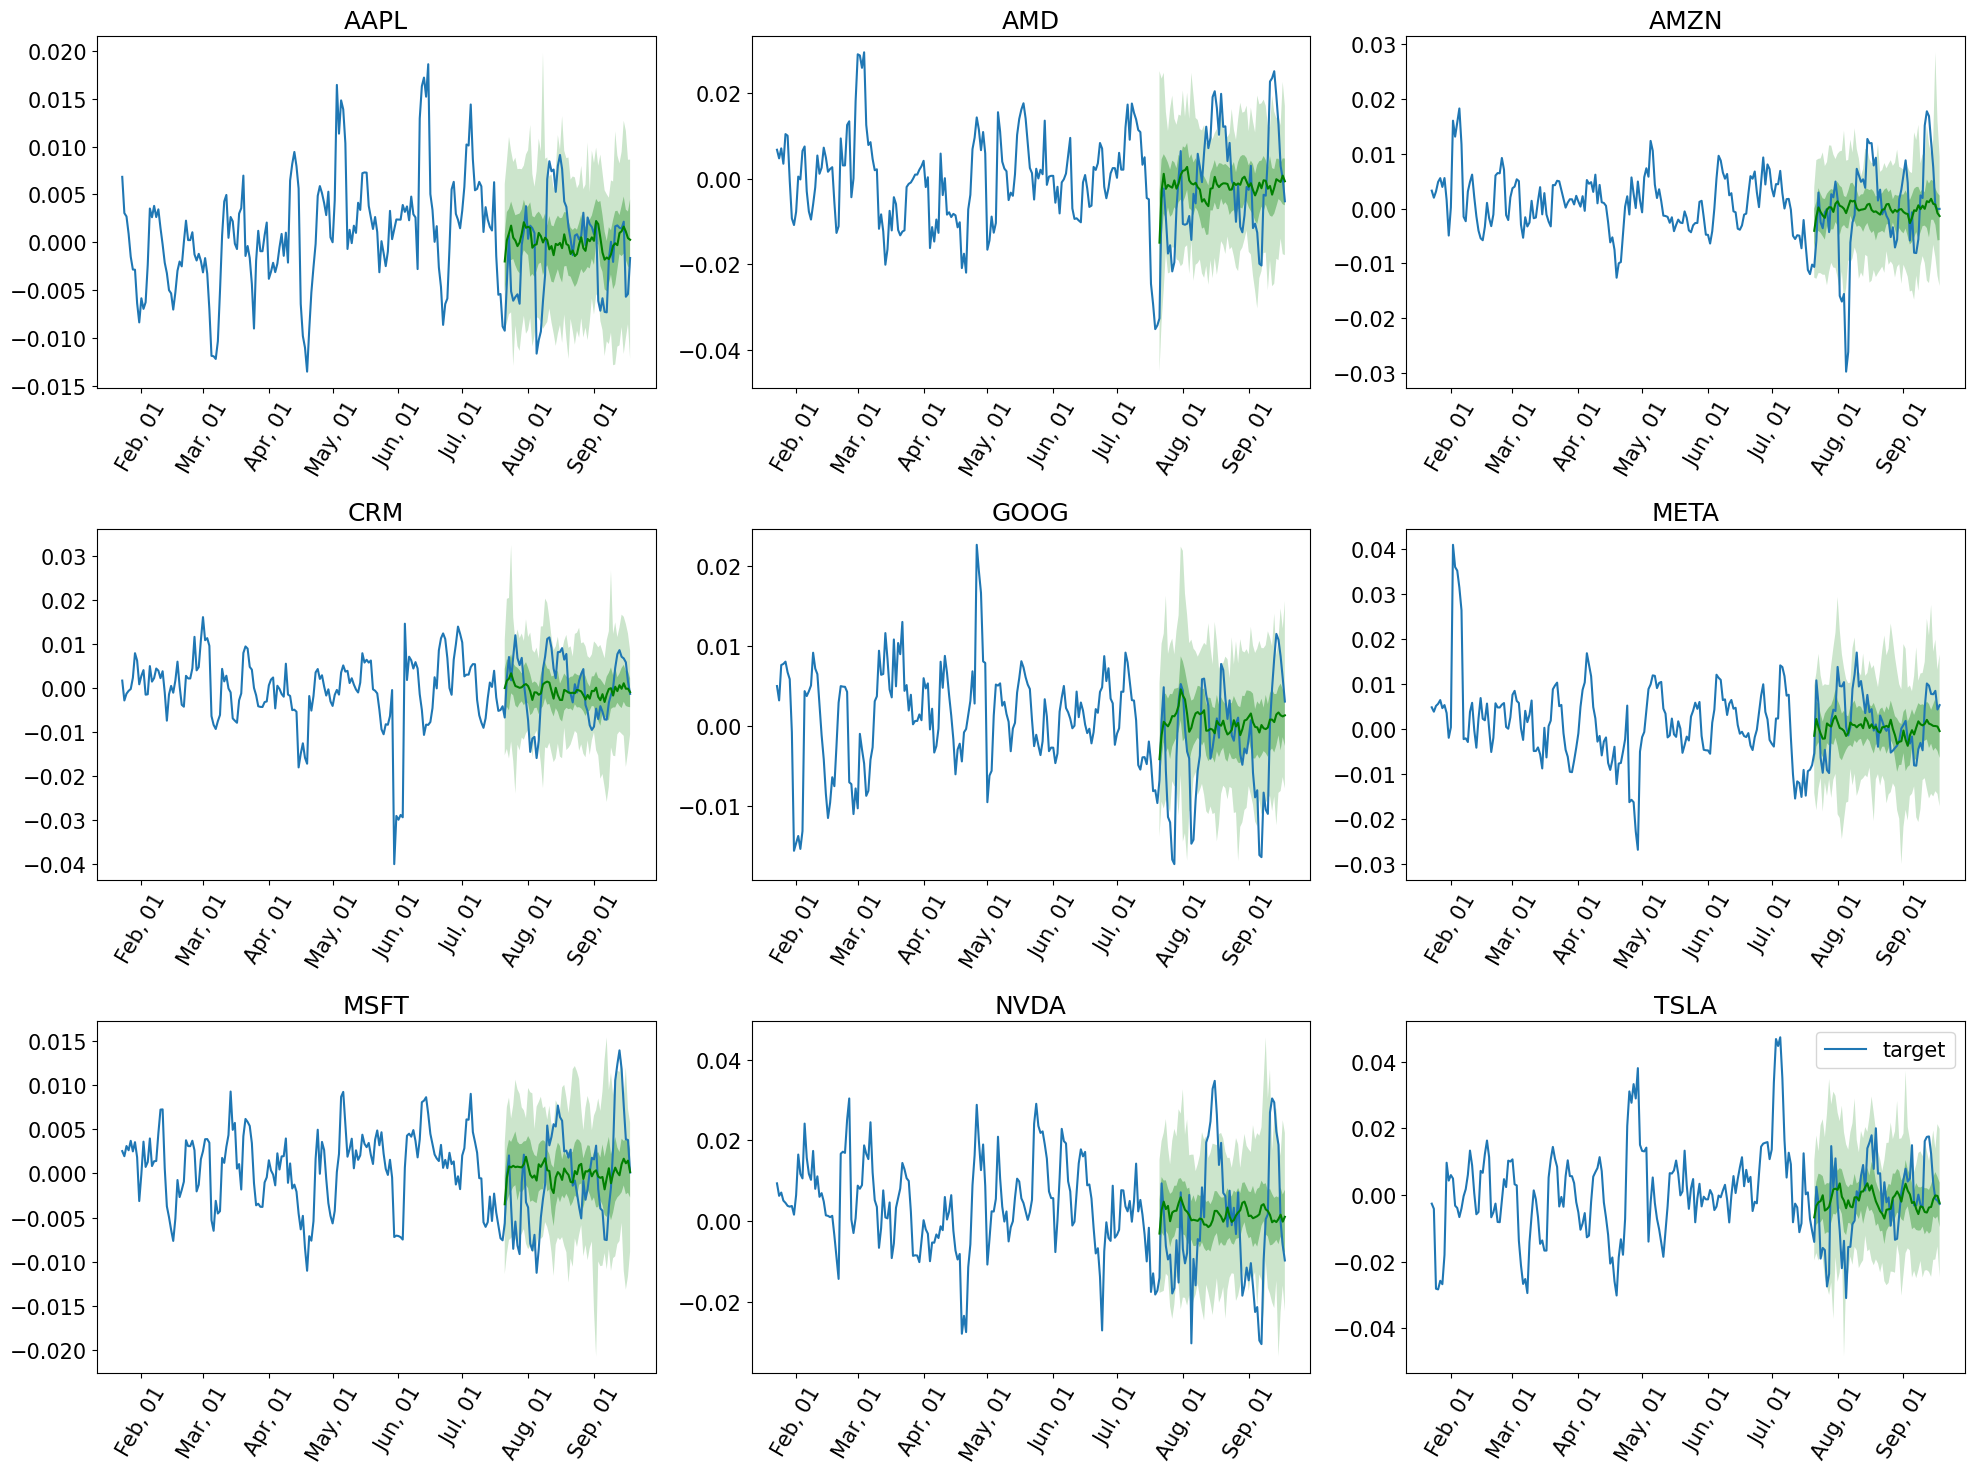

In [34]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [35]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 9it [00:00, 219.97it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [36]:
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])

CRPS: 0.7915368601128198
MSE: 9.687292493051951e-05
MAPE: 1.4694850568418147


In [12]:
#Context Length: 64
forecasts_ctx_len_64, tss_ctx_len_64 = get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=64, use_rope_scaling=False, num_samples=num_samples)
forecasts_ctx_len_64 = list(forecasts_ctx_len_64)
tss_ctx_len_64 = list(tss_ctx_len_64)

agg_metrics_ctx_len_64, ts_metrics_ctx_len_64 = evaluator(iter(tss_ctx_len_64), iter(forecasts_ctx_len_64))
print("CRPS:", agg_metrics_ctx_len_64['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_64['MSE'])
print('MAPE:', agg_metrics_ctx_len_64['MAPE'])

/tmp/ipykernel_925716/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

CRPS: 0.7982097630974804
MSE: 0.00010164356531782283
MAPE: 2.131815239235207


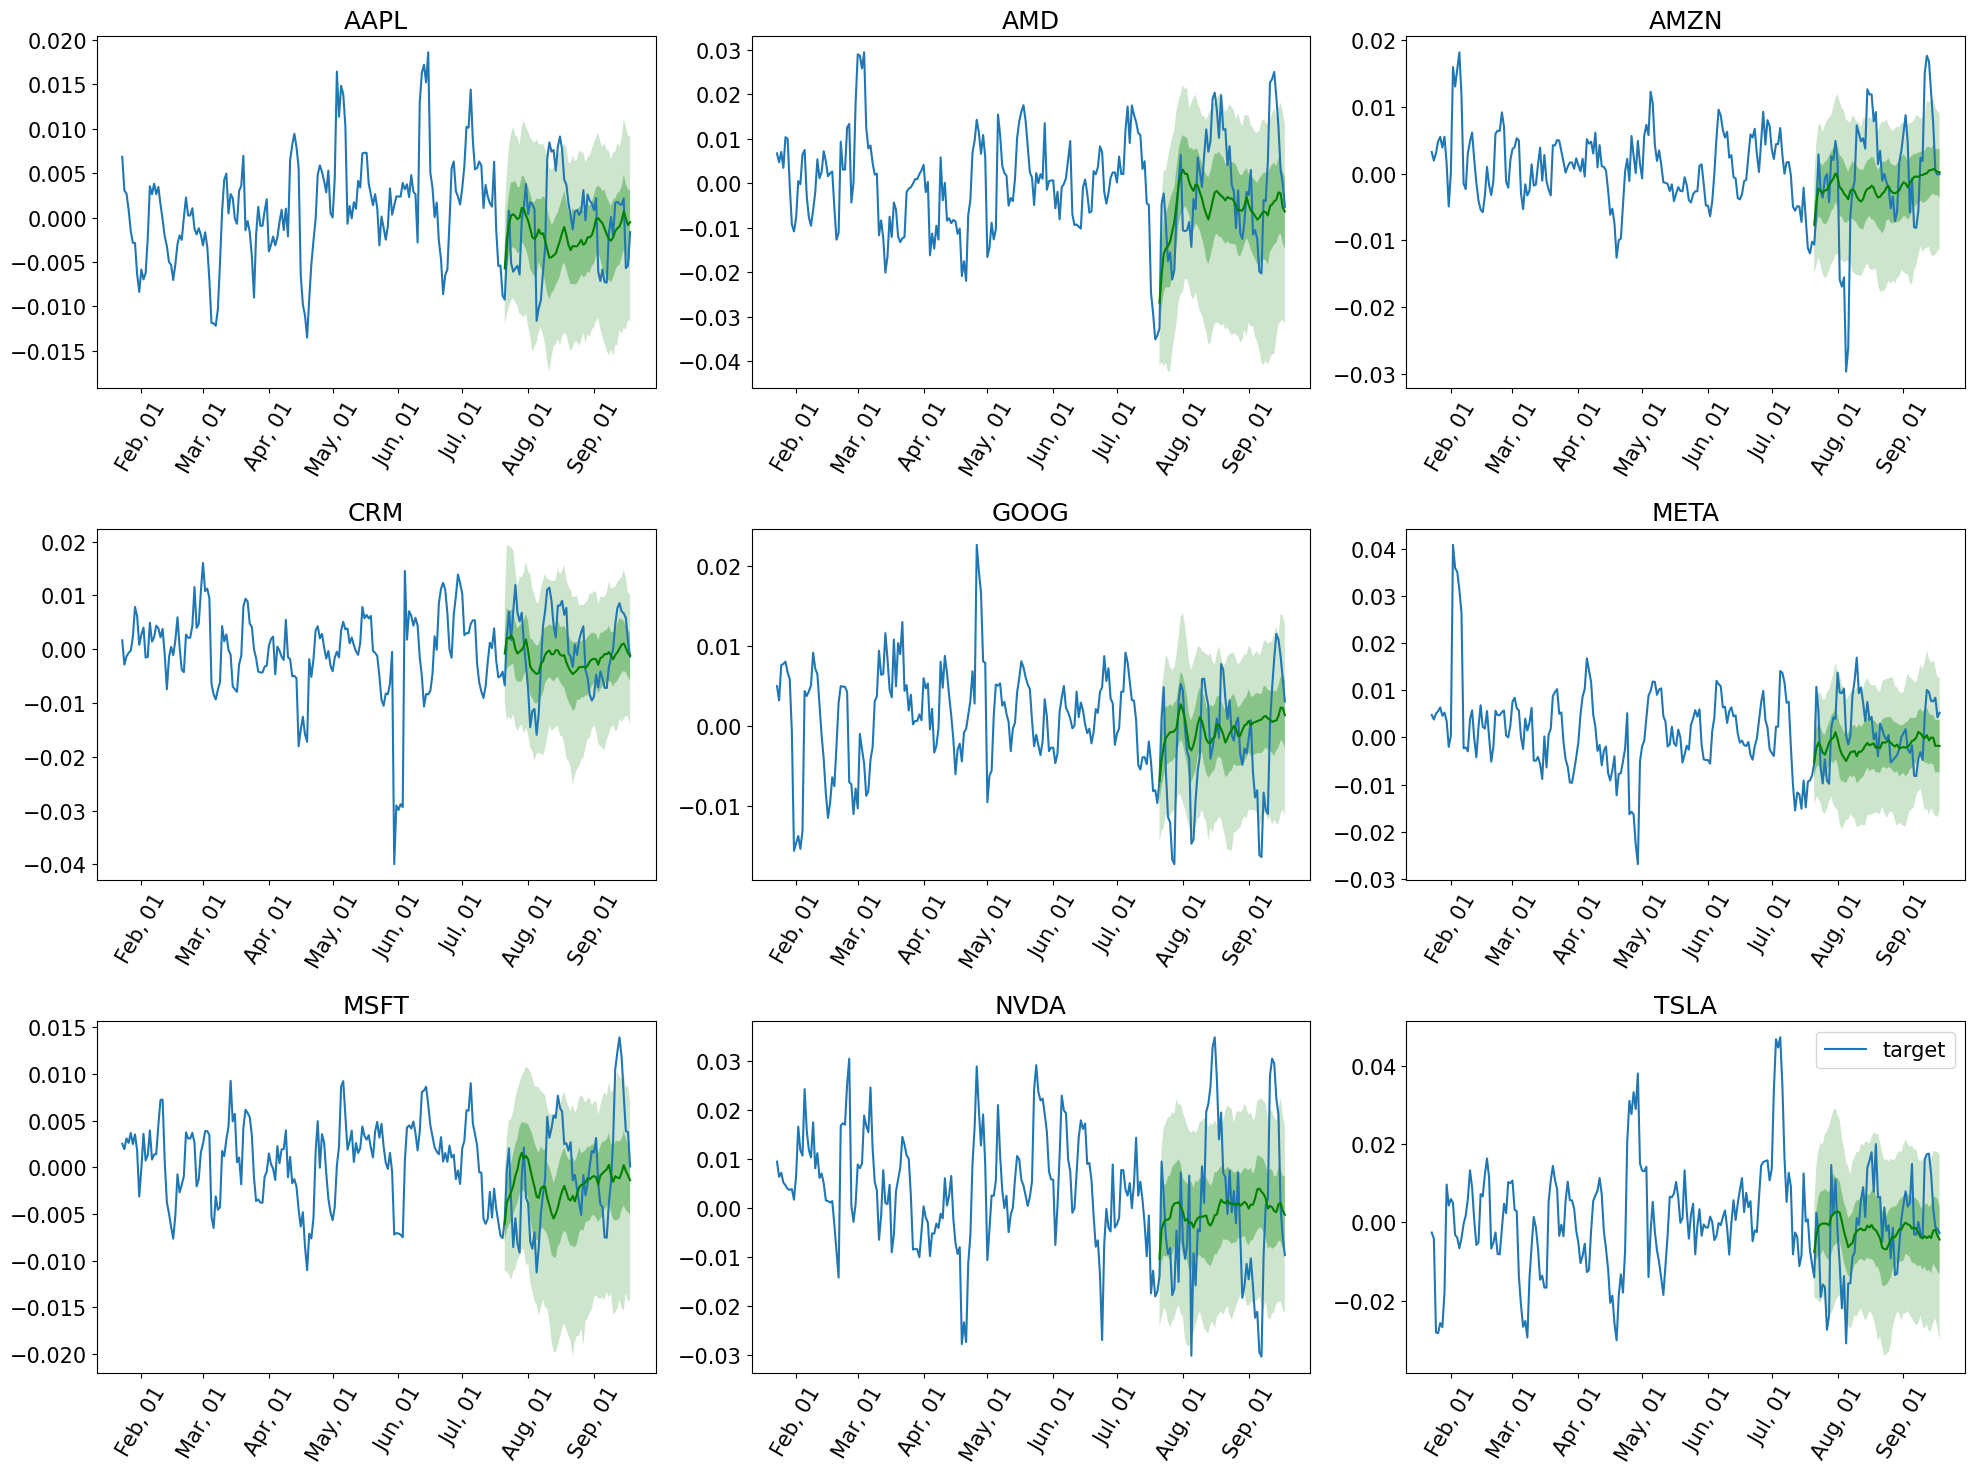

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_64, tss_ctx_len_64)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [17]:
#Context Length: 64 with Rope Scaling
forecasts_ctx_len_64_rp, tss_ctx_len_64_rp = get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=64, use_rope_scaling=True, num_samples=num_samples)
forecasts_ctx_len_64_rp = list(forecasts_ctx_len_64_rp)
tss_ctx_len_64_rp = list(tss_ctx_len_64_rp)

agg_metrics_ctx_len_64_rp, ts_metrics_ctx_len_64_rp = evaluator(iter(tss_ctx_len_64_rp), iter(forecasts_ctx_len_64_rp))
print("CRPS:", agg_metrics_ctx_len_64_rp['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_64_rp['MSE'])
print('MAPE:', agg_metrics_ctx_len_64_rp['MAPE'])

/tmp/ipykernel_925716/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

CRPS: 0.781951413896403
MSE: 9.646392923227892e-05
MAPE: 1.4416257858276367


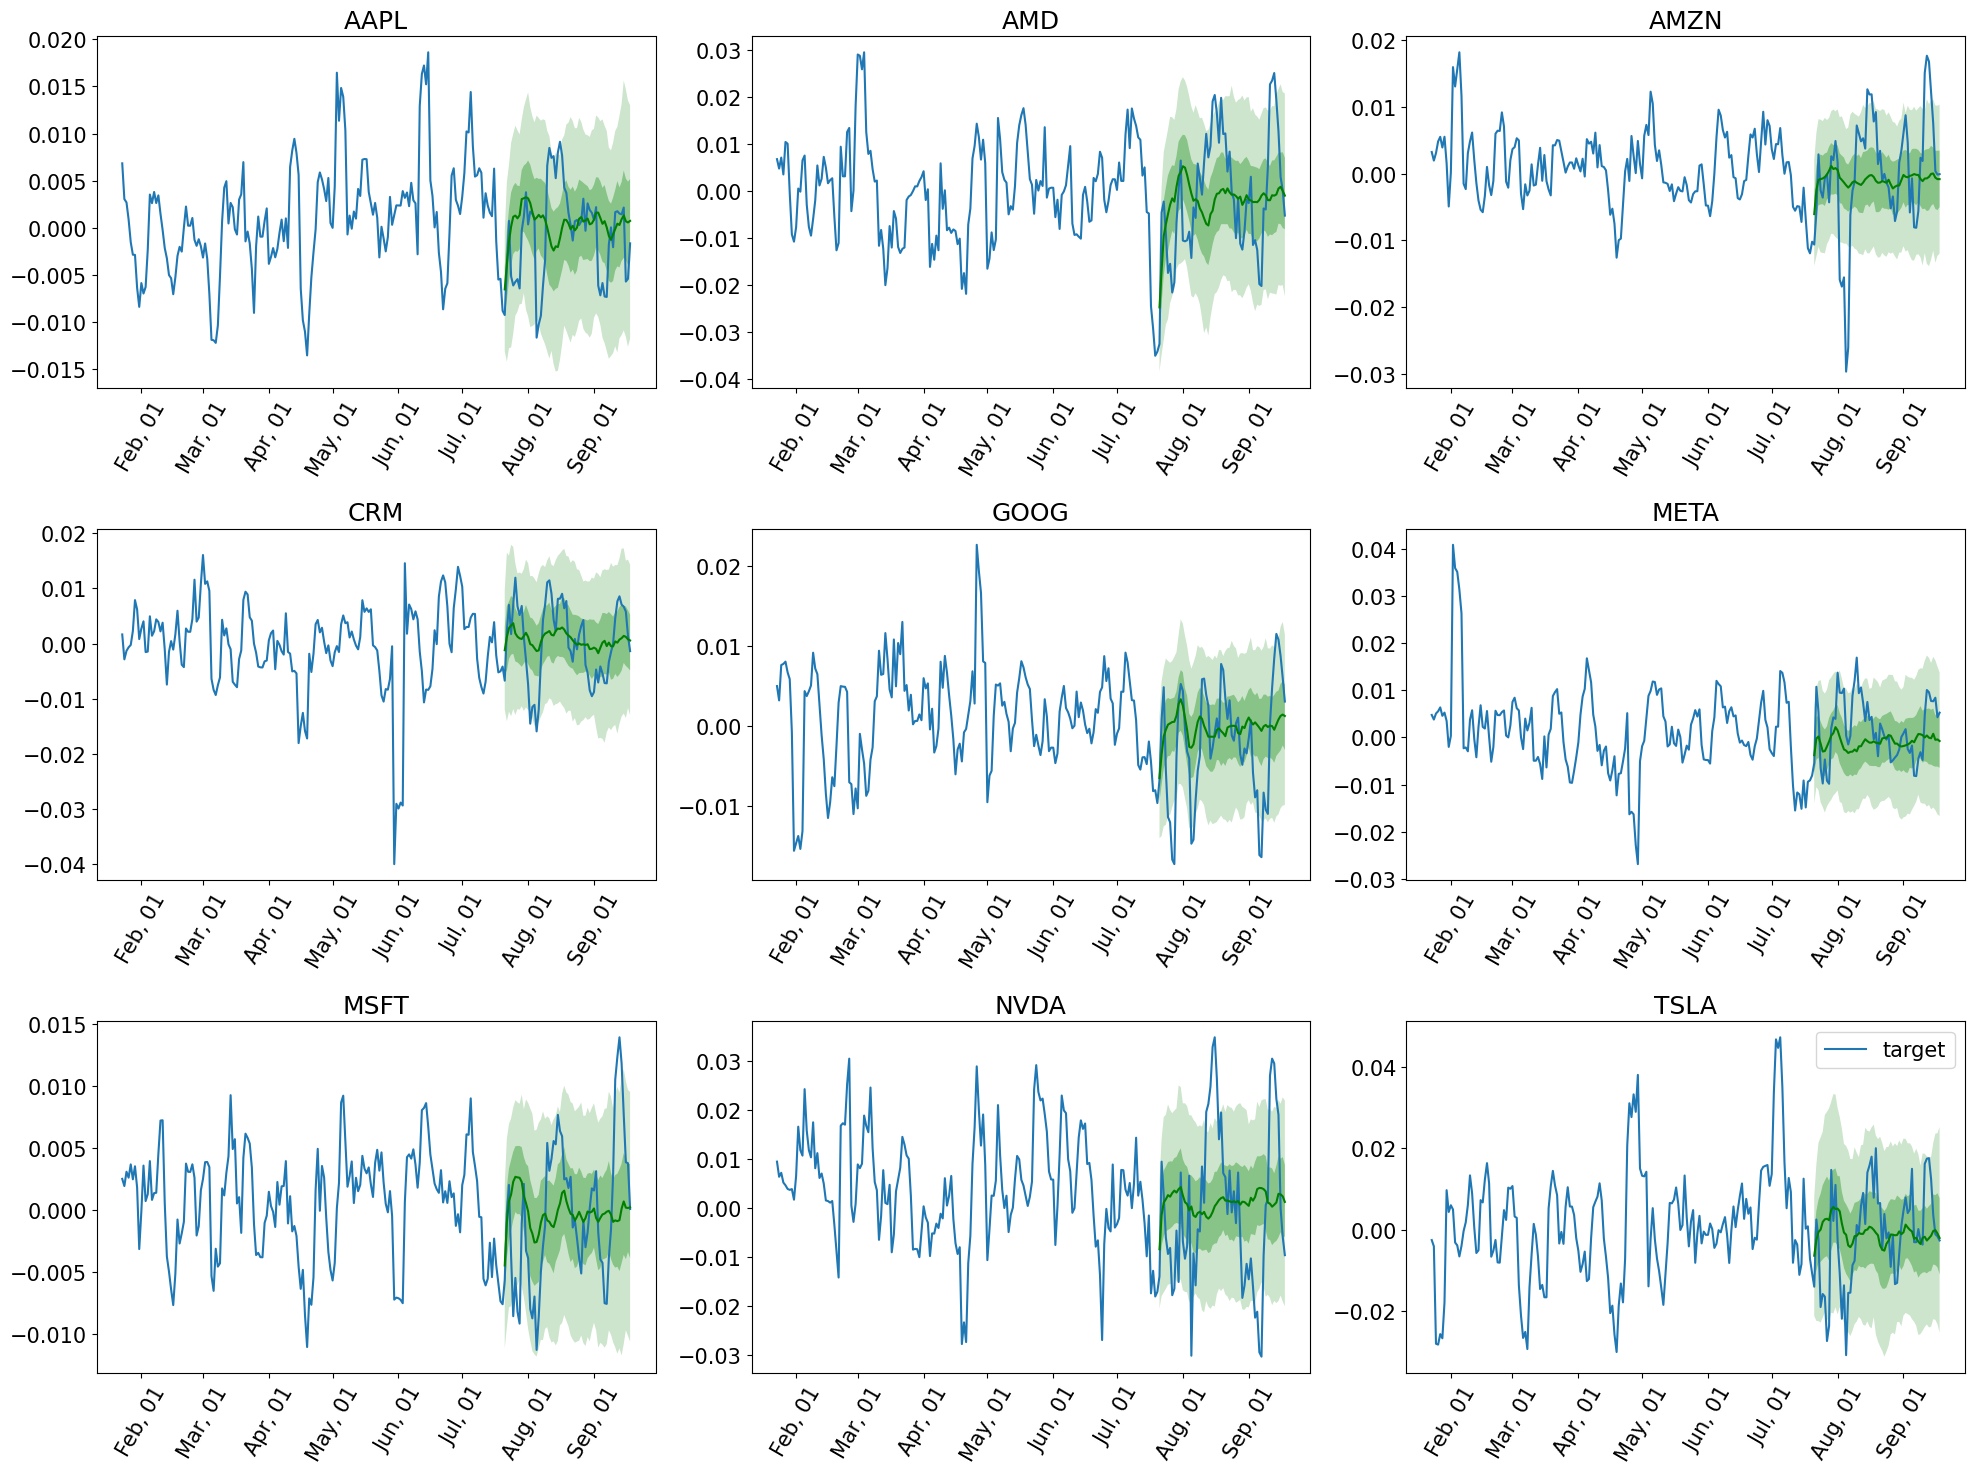

In [18]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_64_rp, tss_ctx_len_64_rp)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Perubahan Context-Length dan penggunaan RoPE Scaling mempengaruhi hasil prediksi serta evaluasi yang dihasilkan.

# Fine-Tuning

In [42]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=512,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

/tmp/ipykernel_927366/3741843831.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)


In [43]:
predictor = estimator.train(
    train_dataset,
    cache_data=True,
    shuffle_buffer_length=1000,
)

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Trainer will use only 1 of 2 GP

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

Epoch 0: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 0, global step 50: 'train_loss' reached -4.04093 (best -4.04093), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 1, global step 100: 'train_loss' reached -4.22409 (best -4.22409), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 2, global step 150: 'train_loss' reached -4.56098 (best -4.56098), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 3, global step 200: 'train_loss' reached -5.03080 (best -5.03080), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 4, global step 250: 'train_loss' reached -5.46658 (best -5.46658), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 5, global step 300: 'train_loss' reached -5.82772 (best -5.82772), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 6, global step 350: 'train_loss' reached -6.10479 (best -6.10479), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 7, global step 400: 'train_loss' reached -6.35300 (best -6.35300), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 8, global step 450: 'train_loss' reached -6.44048 (best -6.44048), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 9, global step 500: 'train_loss' reached -6.64608 (best -6.64608), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 10, global step 550: 'train_loss' reached -6.65281 (best -6.65281), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 11, global step 600: 'train_loss' reached -6.70009 (best -6.70009), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 12, global step 650: 'train_loss' reached -6.82234 (best -6.82234), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 13, global step 700: 'train_loss' reached -6.94581 (best -6.94581), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 14, global step 750: 'train_loss' reached -6.99467 (best -6.99467), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 15, global step 800: 'train_loss' reached -7.01008 (best -7.01008), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 17, global step 900: 'train_loss' reached -7.06003 (best -7.06003), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 18, global step 950: 'train_loss' reached -7.13394 (best -7.13394), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 19, global step 1000: 'train_loss' reached -7.18948 (best -7.18948), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 20, global step 1050: 'train_loss' reached -7.22966 (best -7.22966), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 21, global step 1100: 'train_loss' reached -7.27236 (best -7.27236), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 22, global step 1150: 'train_loss' reached -7.28671 (best -7.28671), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 23, global step 1200: 'train_loss' reached -7.29530 (best -7.29530), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 26, global step 1350: 'train_loss' reached -7.33978 (best -7.33978), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 27, global step 1400: 'train_loss' reached -7.42401 (best -7.42401), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 31, global step 1600: 'train_loss' reached -7.46885 (best -7.46885), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 32, global step 1650: 'train_loss' reached -7.47255 (best -7.47255), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=32-step=1650.ckpt' as top 1


Epoch 33: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 36, global step 1850: 'train_loss' reached -7.56158 (best -7.56158), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=36-step=1850.ckpt' as top 1


Epoch 37: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 38, global step 1950: 'train_loss' reached -7.57809 (best -7.57809), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 39, global step 2000: 'train_loss' reached -7.59448 (best -7.59448), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 41, global step 2100: 'train_loss' reached -7.59866 (best -7.59866), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 42, global step 2150: 'train_loss' reached -7.60607 (best -7.60607), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 43, global step 2200: 'train_loss' reached -7.64296 (best -7.64296), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 48, global step 2450: 'train_loss' reached -7.68433 (best -7.68433), saving model to '/home/abizard/lag-llama/lightning_logs/version_4/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:20<00:00,  2.45it/s, v_num=4]

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [6]:
def _new_get_lag_llama_predictions(dataset, prediction_length, device, context_length=64, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("./lightning_logs/version_4/checkpoints/epoch=48-step=2450.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lightning_logs/version_4/checkpoints/epoch=48-step=2450.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [60]:
forecasts_new_64_norp, tss_new_64_norp = _new_get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=64, use_rope_scaling=False, num_samples=num_samples)

/tmp/ipykernel_927366/3997716346.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lightning_logs/version_4/checkpoints/epoch=48-step=2450.ckpt", map_

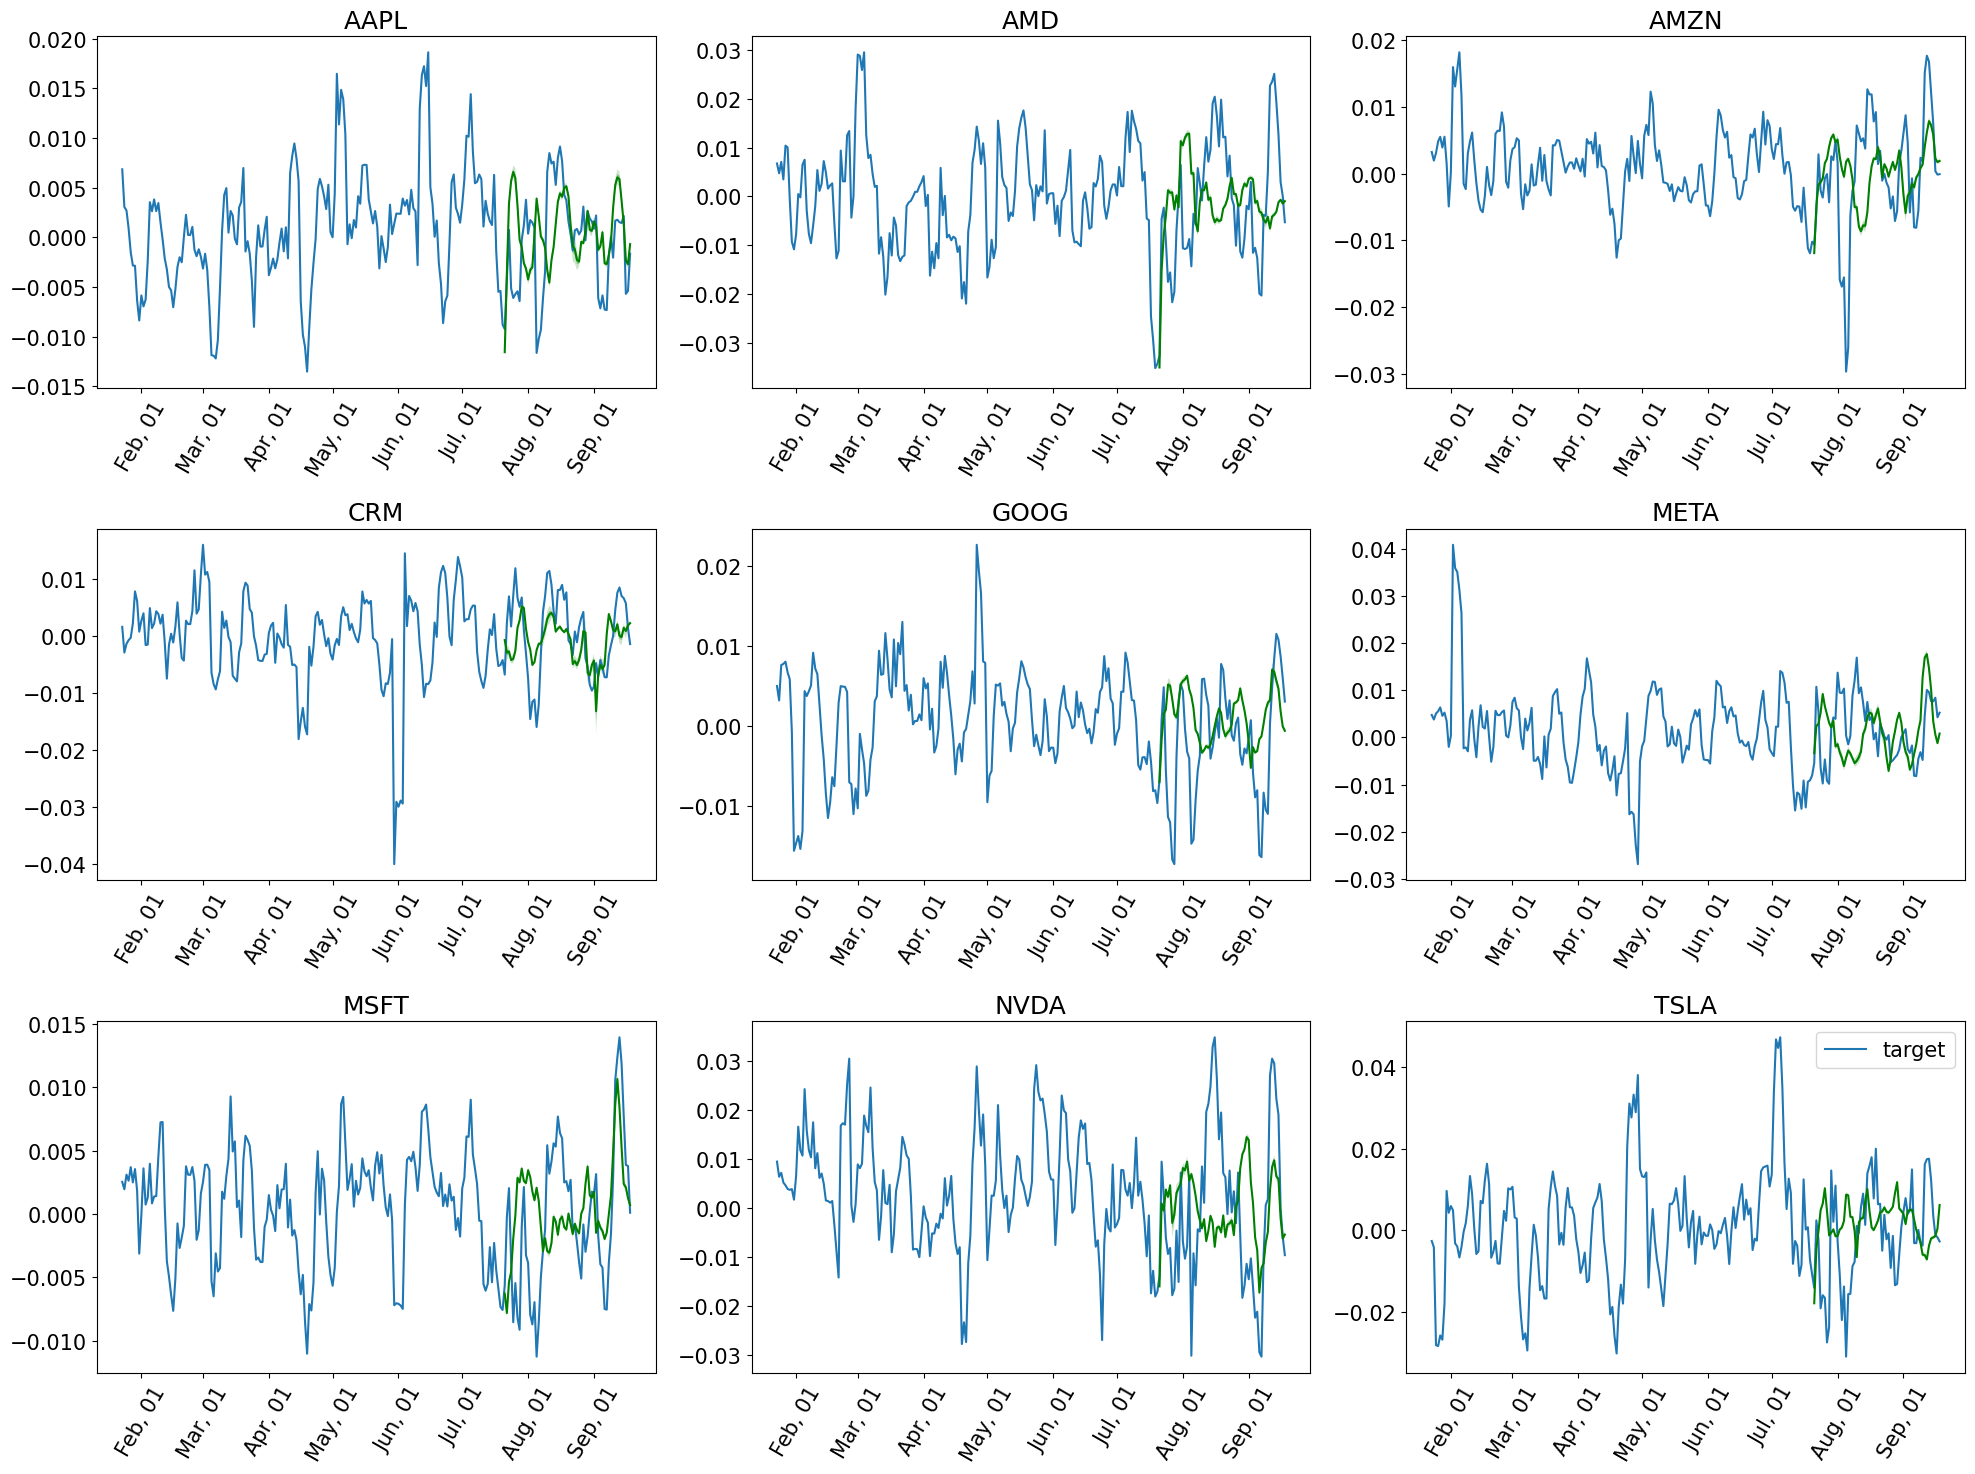

In [61]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_new_64_norp, tss_new_64_norp)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [62]:
evaluator = Evaluator()
agg_metrics_64_new, ts_metrics_64_new = evaluator(iter(tss_new_64_norp), iter(forecasts_new_64_norp))
print('CRPS:', agg_metrics_64_new['mean_wQuantileLoss'])
print('WQL:', agg_metrics_64_new['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics_64_new['MSE'])
print('MAPE:', agg_metrics_64_new['MAPE'])

Running evaluation: 9it [00:00, 285.93it/s]


CRPS: 1.068567441118376
WQL: 0.9609778566533227
MSE: 0.0001174377661232871
MAPE: 2.097004106309679


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [57]:
forecasts_new_64, tss_new_64 = _new_get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=64, use_rope_scaling=True, num_samples=num_samples)

/tmp/ipykernel_927366/3997716346.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lightning_logs/version_4/checkpoints/epoch=48-step=2450.ckpt", map_

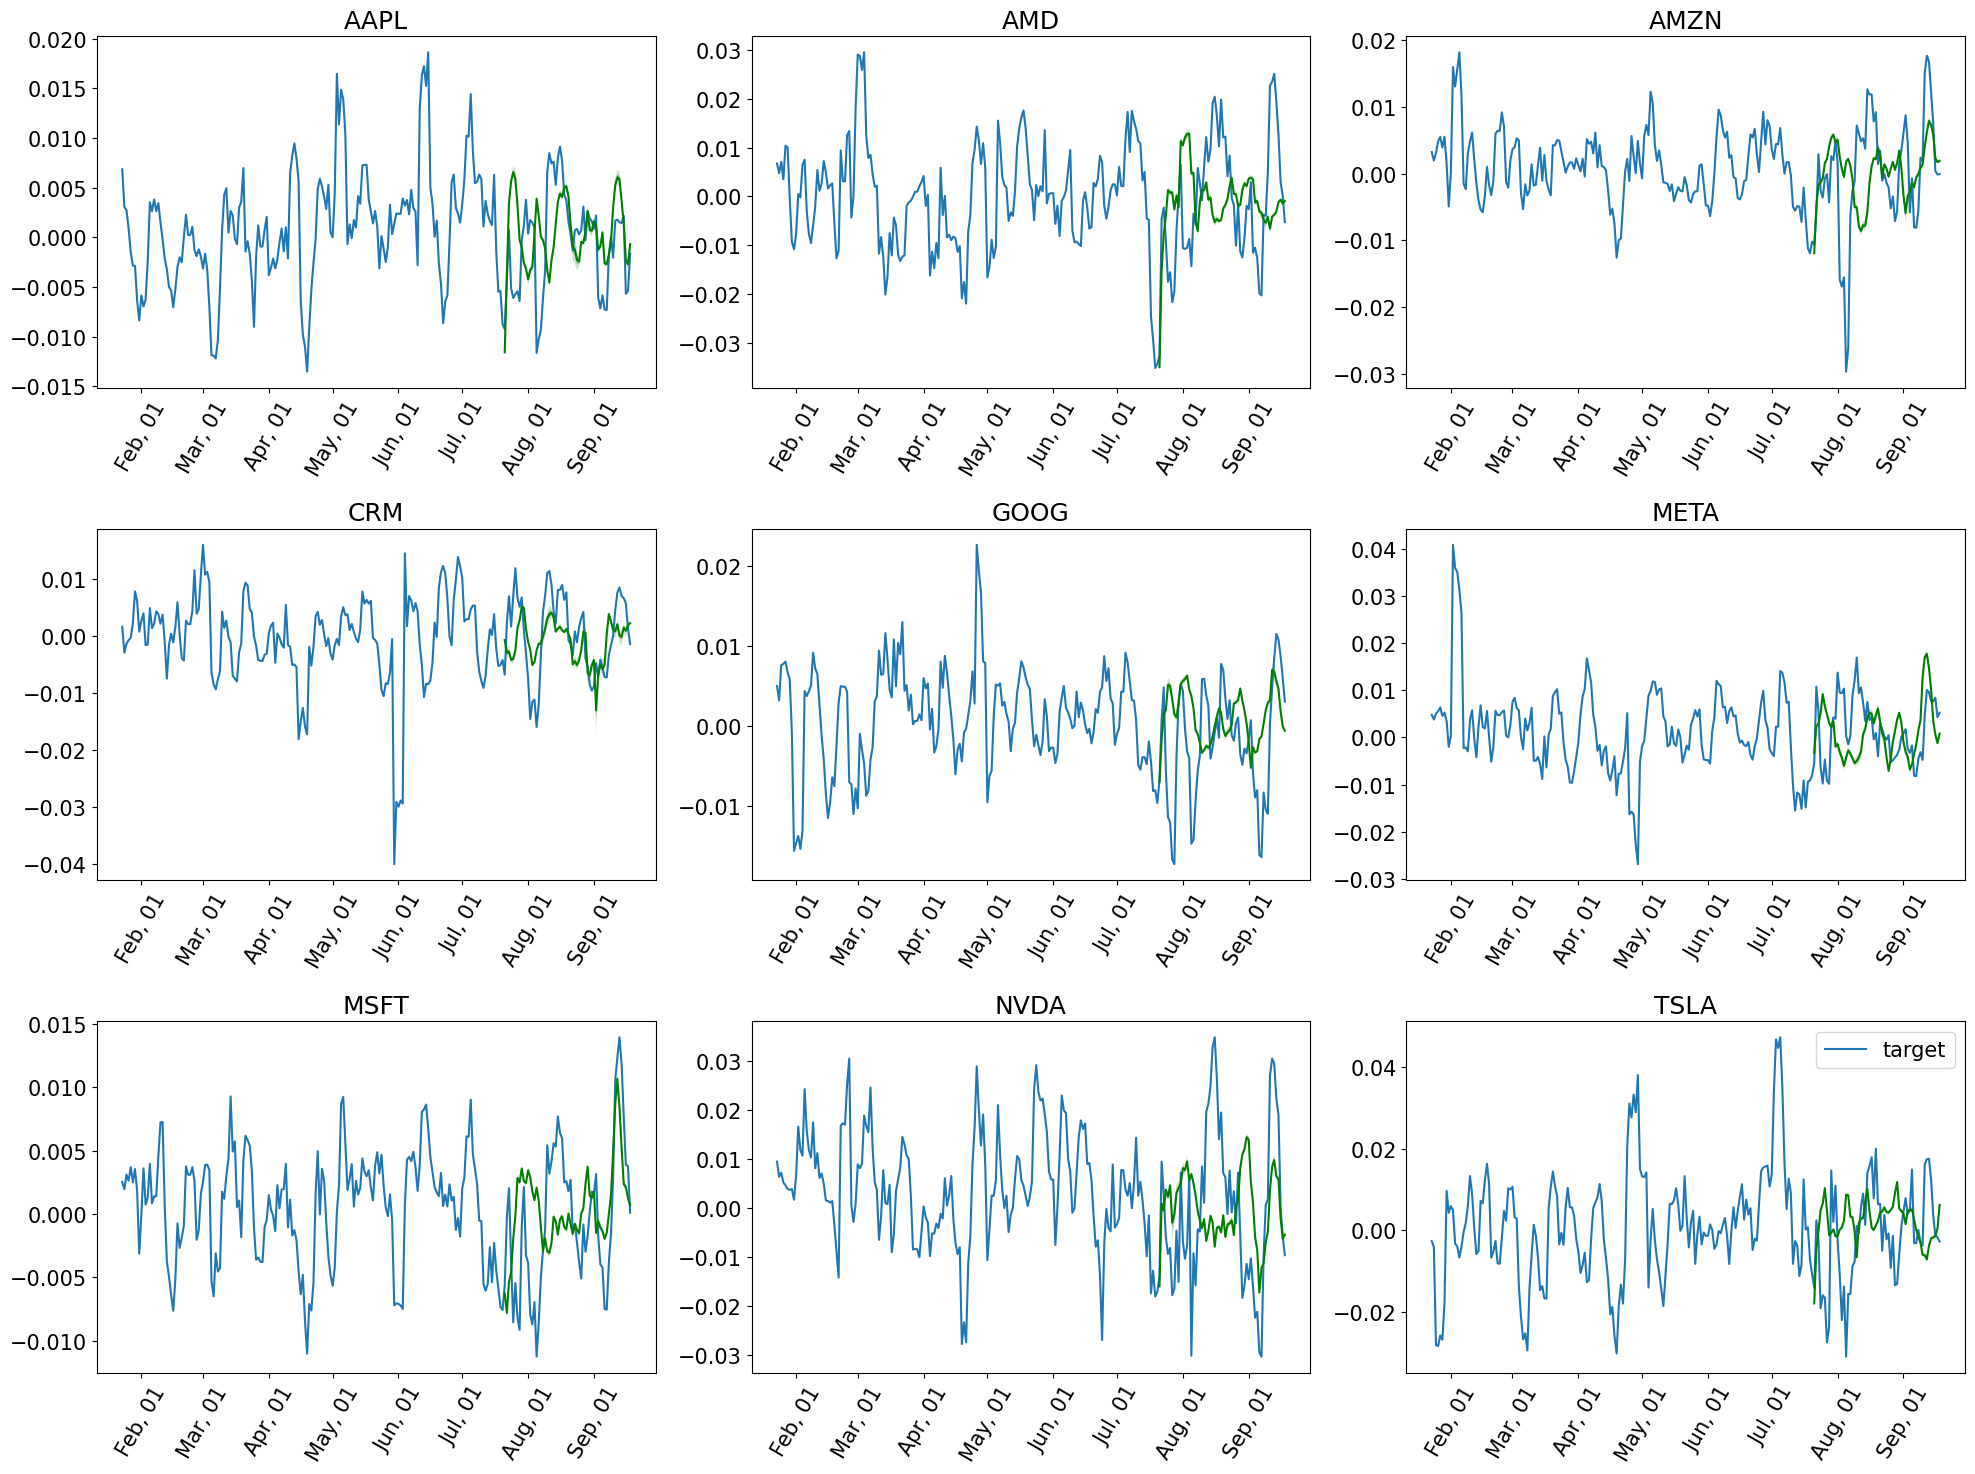

In [58]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_new_64, tss_new_64)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [59]:
evaluator = Evaluator()
agg_metrics_64_new, ts_metrics_64_new = evaluator(iter(tss_new_64), iter(forecasts_new_64))
print('CRPS:', agg_metrics_64_new['mean_wQuantileLoss'])
print('WQL:', agg_metrics_64_new['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics_64_new['MSE'])
print('MAPE:', agg_metrics_64_new['MAPE'])

Running evaluation: 9it [00:00, 291.40it/s]


CRPS: 1.068471515223337
WQL: 0.9611798497435476
MSE: 0.00011739855873639937
MAPE: 2.0967724411575883


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [54]:
forecasts_new, tss_new = _new_get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=512, use_rope_scaling=True, num_samples=num_samples)

/tmp/ipykernel_927366/3997716346.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lightning_logs/version_4/checkpoints/epoch=48-step=2450.ckpt", map_

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

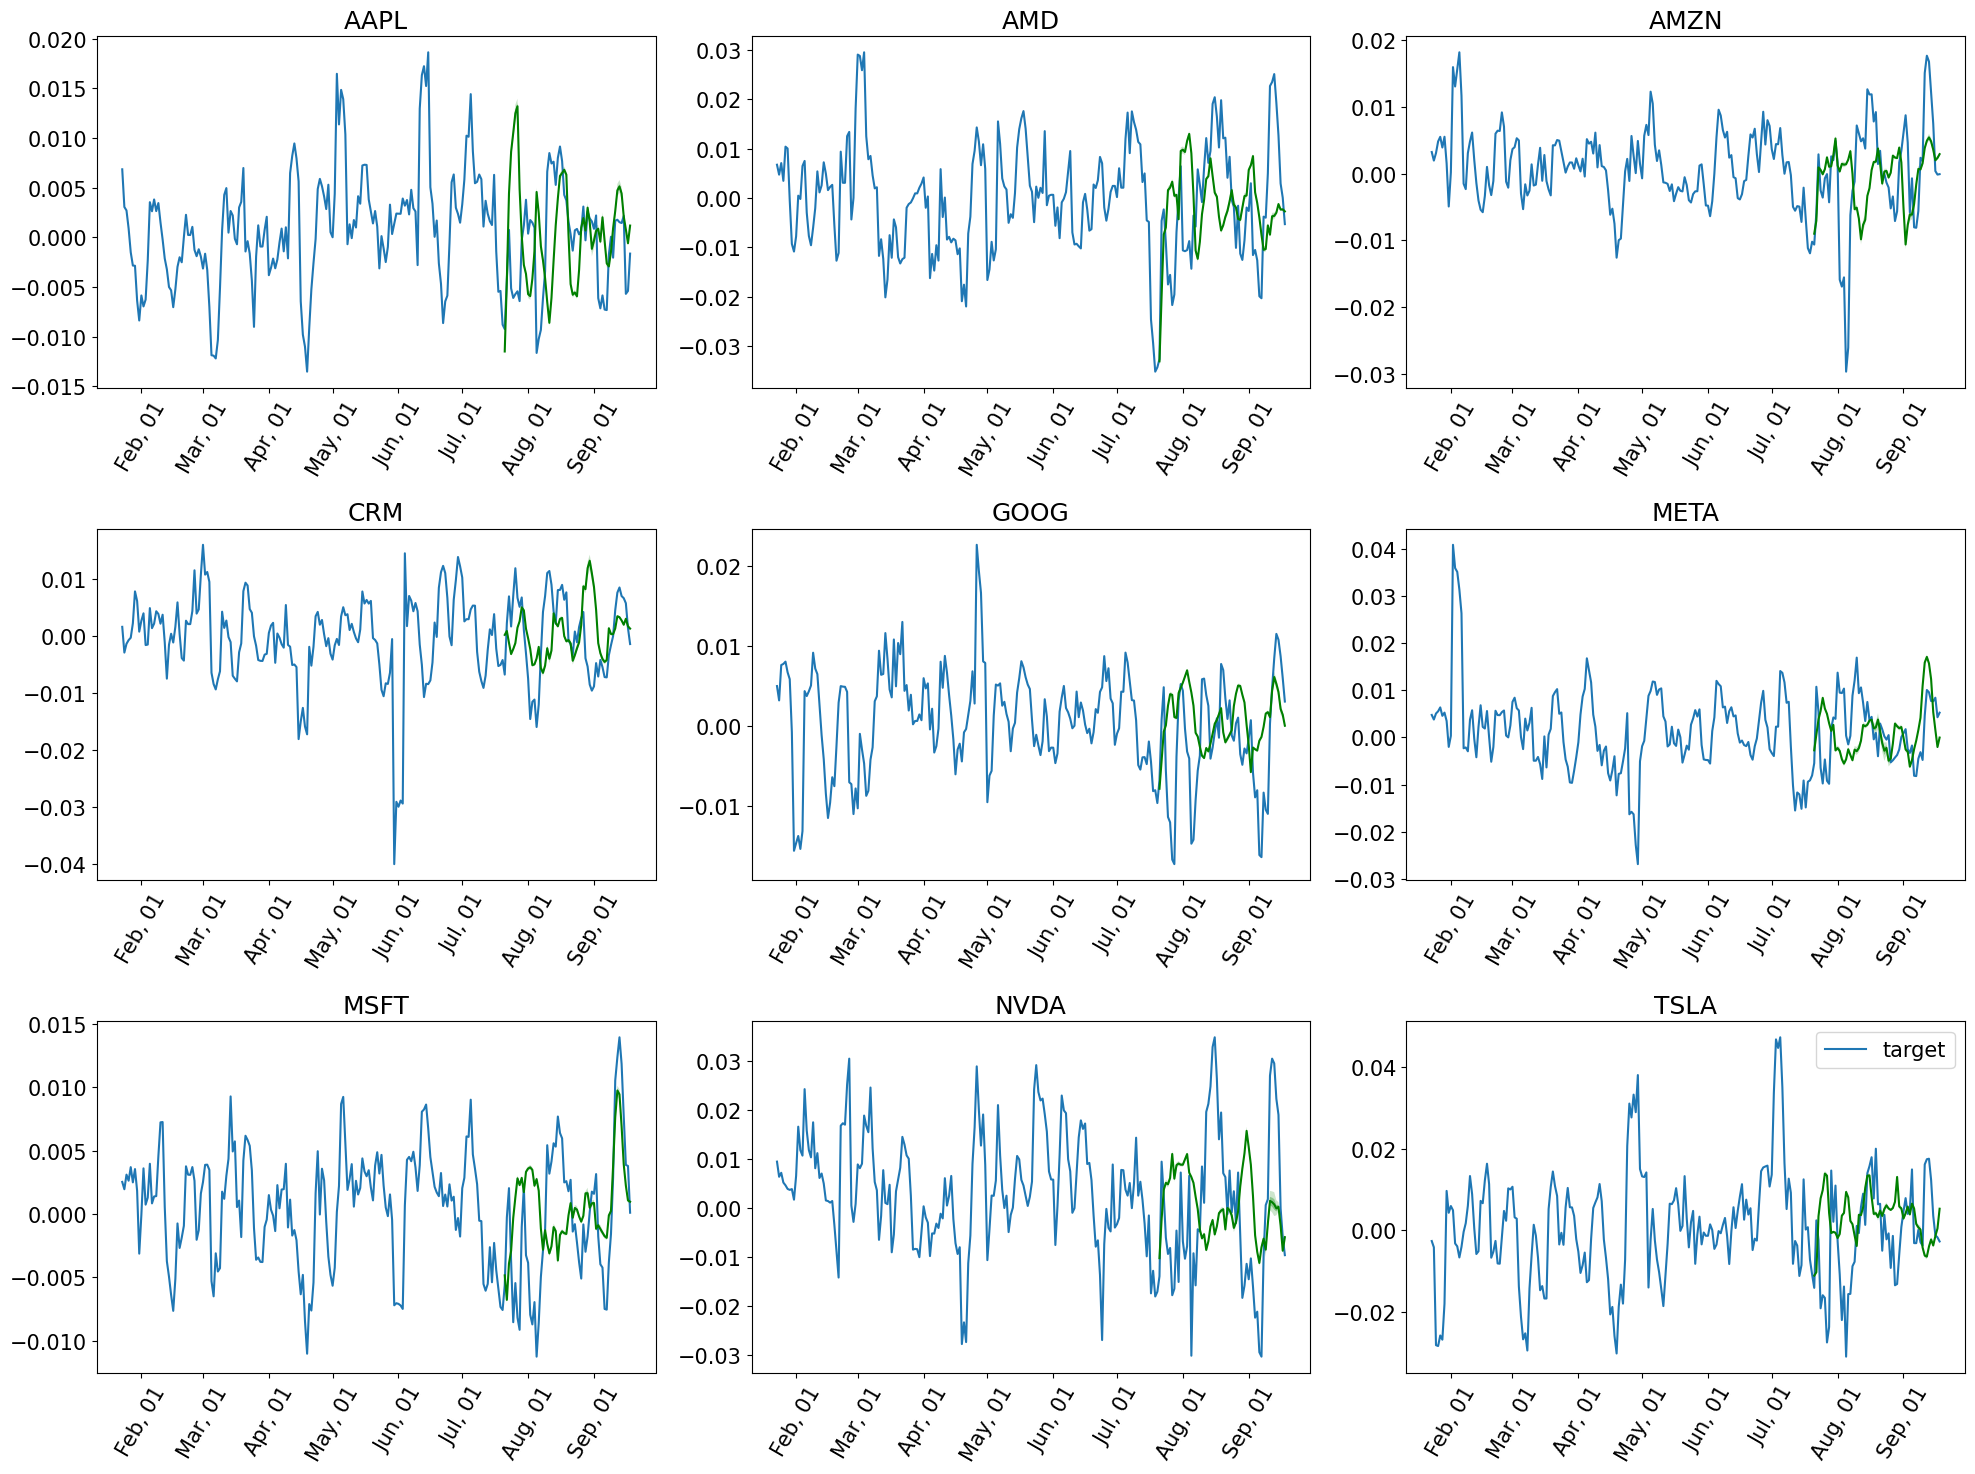

In [55]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_new, tss_new)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [56]:
evaluator = Evaluator()
agg_metrics_new, ts_metrics_new = evaluator(iter(tss_new), iter(forecasts_new))
print('CRPS:', agg_metrics_new['mean_wQuantileLoss'])
print('WQL:', agg_metrics_new['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics_new['MSE'])
print('MAPE:', agg_metrics_new['MAPE'])

Running evaluation: 9it [00:00, 299.34it/s]


CRPS: 1.129190297439224
WQL: 1.0005695914035302
MSE: 0.00013060008555098814
MAPE: 2.166641150580512


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
